In [1]:
# %matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
import numpy as np
import plotly.graph_objects as go

In [2]:

@dataclass
class Node:
    id : int
    x : float
    """ x position in the area [km]"""
    y : float
    """ y position in the area [km]"""
    trans_power : float = 30
    """Transmit power in dBm"""
    sensitivity : float = -50
    """Sensitivity in dBm"""
    antenna_gain : float = 1
    """anntenna gain in dbi"""
    frequency: float = 100
    """ frequency in MHz"""


In [3]:
@dataclass
class NodesDistributionParams:
    area_size_x: float = 30
    """area size in km"""
    area_size_y: float = 30
    """area size in km"""
    nodes_minimal_distance:float =  0.5
    """ nodes minimal distance [km] - required for loss model"""
    nodes_count: int = 100
    """ nodes in area"""


In [4]:
def get_random_position(sample_params:NodesDistributionParams):
    x,y = np.random.random(2)
    x = sample_params.area_size_x*x
    y = sample_params.area_size_y*y
    return x,y

def get_last_minimal_distance(x:np.ndarray,y:np.ndarray):
    dx = x[-1]-x[:-1]
    dy = y[-1]-y[:-1]
    d = dx**2 +dy**2
    dmin  = d.min()
    return np.sqrt(dmin)


def create_nodes_samples(sample_params:NodesDistributionParams):
    nodes:list[Node] =[]
    x_vec = np.zeros(sample_params.nodes_count)
    y_vec = np.zeros(sample_params.nodes_count)
    x,y = get_random_position(sample_params)
    x_vec[0]=x 
    y_vec[0]=y
    nodes.append(Node(0,x,y))
    for i in range(1,sample_params.nodes_count):
        min_dist = 0
        while min_dist<sample_params.nodes_minimal_distance:
            x,y =get_random_position(sample_params) 
            x_vec[i]=x
            y_vec[i]=y
            min_dist = get_last_minimal_distance(x_vec[:(i+1)],y_vec[:(i+1)])
        nodes.append(Node(i,x,y))
    return nodes



In [5]:
def visualize_nodes(nodes:list[Node],fig):
    x_list = np.array([node.x for node in nodes])
    y_list = np.array([node.y for node in nodes])
    scatter_trace = go.Scatter(x=x_list, y=y_list, mode='markers',name='Nodes')
    fig.add_trace(scatter_trace)
    

In [6]:
def free_space_path_loss(distance_km, frequency_mhz):
    # Convert distance from kilometers to meters
    distance_m = distance_km * 1000

    # Convert frequency from megahertz to hertz
    frequency_hz = frequency_mhz * 1e6

    # Calculate the free space path loss using the Friis transmission equation
    path_loss_db = 20 * np.log10(distance_m) + 20 * np.log10(frequency_hz) + 20 * np.log10(4 * np.pi / 3e8)

    return path_loss_db

def loss_freespace(d:np.ndarray,freq:float = 100):
    l = 20*np.log10(d) + 20*np.log10(freq) - 147.55
    return l

In [7]:
nodes = create_nodes_samples(NodesDistributionParams())
fig = go.Figure()

visualize_nodes(nodes,fig)

# Update the layout
fig.update_layout(
    title='Nodes',
    xaxis_title='km',
    yaxis_title='km',
    width=1000,
    height=1000

)




In [8]:
from itertools import product


def create_distance_matrix(nodes:list[Node]):
    l = len(nodes)
    matrix = np.zeros((l,l))
    for idx1,idx2 in product(range(l),range(l)):
        matrix[idx1,idx2] = (nodes[idx1].x - nodes[idx2].x)**2 + (nodes[idx1].y - nodes[idx2].y)**2

    matrix = np.sqrt(matrix)
    return matrix


def create_recieve_power_matrix(nodes:list[Node]):
    dists = create_distance_matrix(nodes) + 1000*np.eye(len(nodes))
    loss_matrix = free_space_path_loss(dists,nodes[0].frequency)
    power_vec = np.array([node.trans_power for node in nodes])
    antenna_gain_vec  = np.array([node.antenna_gain for node in nodes])

    recieve_power = power_vec[:,None] - loss_matrix  + antenna_gain_vec[:,None] +  antenna_gain_vec[None,:]
    recieve_power = (1-np.eye(len(nodes))) * recieve_power + -1000*np.eye(len(nodes))
    return  recieve_power

def create_connectivity_matrix(nodes:list[Node]):
    recieve_power = create_recieve_power_matrix(nodes)
    sensitivities = np.array([node.sensitivity for node in nodes])

    connectivity_matrix = recieve_power >= sensitivities[None,:]
    return connectivity_matrix

In [9]:
d = create_distance_matrix(nodes) + 1000*np.eye(len(nodes))
d.min()

0.5486625421280005

In [10]:
cmatrix = create_connectivity_matrix(nodes)
np.all(cmatrix)

False

In [11]:
cmatrix = (cmatrix | (np.eye(cmatrix.shape[0])==1))

In [12]:
def visualize_cmatrix(nodes:list[Node],cmatrix:np.ndarray,fig):
    l = len(nodes)
    for idx1,idx2 in product(range(l),range(l)):
        if idx1==idx2:
            continue
        if cmatrix[idx1,idx2]:
            x1 = nodes[idx1].x
            y1 = nodes[idx1].y
            x2 = nodes[idx2].x
            y2 = nodes[idx2].y
            fig.add_trace(go.Scatter(x=[x1, x2], y=[y1, y2], mode='lines', line=dict(color='black'),showlegend=False))
            #break


In [13]:
fig = go.Figure()

visualize_nodes(nodes,fig)
visualize_cmatrix(nodes,cmatrix,fig)
# Update the layout
fig.update_layout(
    title='Nodes',
    xaxis_title='km',
    yaxis_title='km',
    width=1000,
    height=1000

)


In [14]:
np.all(cmatrix)

False

In [15]:
import matplotlib.pyplot as plt
import mplcursors


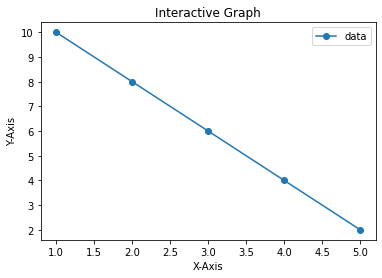

In [16]:
# Sample data
x_values = [1, 2, 3, 4, 5]
y_values = [10, 8, 6, 4, 2]

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
line, = ax.plot(x_values, y_values, 'o-', label='data')

# Set labels and title
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title('Interactive Graph')

# Add legend
ax.legend()

# Enable cursor interaction
mplcursors.cursor(line)

# Display the plot
plt.show()


In [17]:
import numpy as np
import plotly.graph_objects as go

# Sample data
x_values = np.array([1, 2, 3, 4, 5])
y_values = np.array([10, 8, 6, 4, 2])

# Create a scatter plot figure
fig = go.Figure(data=go.Scatter(x=x_values, y=y_values, mode='markers'))

# Update the layout
fig.update_layout(
    title='Scatter Plot',
    xaxis_title='X-Axis',
    yaxis_title='Y-Axis'
)

# Display the figure
fig.show()
